## Experimenting with loss Truncation

Based on the paper: <i>Improved Natural Language Generation via Loss Truncation</i>. In broad strokes, they show that adaptively removing high loss examples is a method to optimize for distinguishability.

In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy # log-loss
import numpy as np
import matplotlib.pyplot as plt
tf.keras.backend.set_floatx('float32')

import warnings
warnings.filterwarnings('ignore')

In [2]:
def generate_data(distributions):
    """ generates 1-D data from Gaussian
    args:
        distributions: list of tuples of type:(mean,stdev,n_examples)
    """
    full_data = []
    for dist_tup in distributions:
        mu,sigma,n_examples = dist_tup
        data_points = np.random.normal(mu,sigma,n_examples)
        full_data.append(data_points)
        
    full_data = np.expand_dims(np.concatenate(full_data).astype("float32"),axis=-1)
    return full_data

In [3]:
example_data = generate_data([(1,1,7450),(14,1,2550)])
experimental_data = generate_data([(1,1,4900),(14,1,2550),(10,1,2550)])
print(example_data.shape,experimental_data.shape)

(10000, 1) (10000, 1)


In [4]:
def gaussian_likelihood(x_subset,mu,sigma,pi=3.141592):
    """ likelihood function for the gaussian
    """
    return (1/(sigma*tf.sqrt(2*pi)))*tf.exp(-(((x_subset-mu)**2)/(2*(sigma**2))))

In [5]:
def fit_gaussian_log_loss(x,n_epochs=20,batch_size=50,optimizer=SGD(0.1),e=1e-15,print_loss=False):
    """ using the input data x, uses log loss to fit single Gaussian
    """
    mu,sigma = tf.Variable(7.0,trainable=True),tf.Variable(1.0,trainable=True) # initialized to standard normal
    
    np.random.shuffle(x)
    for _ in range(n_epochs):
        losses = []
        for i in range(0,len(x),batch_size):
            x_subset = x[i:i+batch_size]
            with tf.GradientTape() as tape:
                batch_likelihood = gaussian_likelihood(x_subset,mu,sigma)
                loss = tf.reduce_mean(-tf.math.log(tf.maximum(batch_likelihood,e))) # log loss, e used for numerical stability
            
            gradients = tape.gradient(loss,[mu,sigma])
            optimizer.apply_gradients(zip(gradients,[mu,sigma]))
            losses.append(float(loss))
        if print_loss:
            print("epoch {}: {}".format(_+1,sum(losses)/len(losses)))
    return mu,sigma

In [6]:
def fit_gaussian_truncated_loss(x,mu,sigma,c=0.2,n_epochs=20,batch_size=50,optimizer=SGD(0.1),e=1e-15,print_loss=False):
    """ using the input data x and "hotstarted" mu & sigma, uses truncated log loss to fit single Gaussian
        -len(x)=10000, so 1-c fraction of the data is calculated over the entire input
    """
    
    np.random.shuffle(x)
    for _ in range(n_epochs):
        # calculating 1-c quantile and generating loss mask
        likelihoods = (-tf.math.log(tf.maximum(gaussian_likelihood(x,mu,sigma),e))).numpy()
        c_quantile = np.quantile(likelihoods,1-c)
        x_loss_mask = (likelihoods<c_quantile).astype("float32")
        
        losses = []
        for i in range(0,len(x),batch_size):
            x_subset = x[i:i+batch_size]
            batch_loss_mask = x_loss_mask[i:i+batch_size]
            with tf.GradientTape() as tape:
                batch_likelihood = gaussian_likelihood(x_subset,mu,sigma)
                loss = tf.reduce_mean(-tf.math.log(tf.maximum(batch_likelihood,e))*batch_loss_mask) # log loss, e used for numerical stability
            
            gradients = tape.gradient(loss,[mu,sigma])
            optimizer.apply_gradients(zip(gradients,[mu,sigma]))
            losses.append(float(loss))
        if print_loss:
            print("epoch {}: {}".format(_+1,sum(losses)/len(losses)))
    return mu,sigma

### Replicating Figure 1

Note: this is not a direct replication as the number of examples for each gaussian vary.

In [7]:
mu,sigma = fit_gaussian_log_loss(example_data,print_loss=False)
log_loss_data = np.random.normal(mu,sigma,10000)
mu,sigma = fit_gaussian_truncated_loss(example_data,mu,sigma,print_loss=False)
distinguishability_data = np.random.normal(mu,sigma,10000)

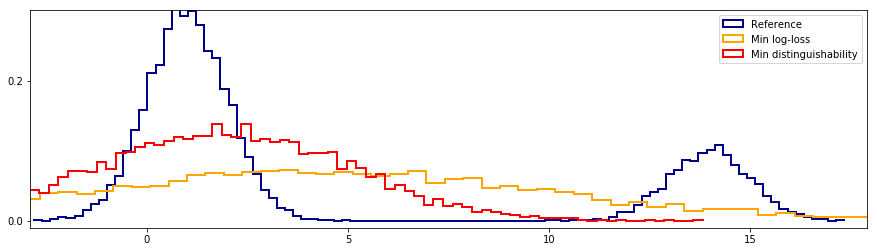

In [8]:
plt.figure(figsize=(15,4))
plt.hist(example_data,density=True,bins=100,histtype="step",color="darkblue",linewidth=2,label="Reference")
plt.hist(log_loss_data,density=True,bins=100,histtype="step",color="orange",linewidth=2,label="Min log-loss")
plt.hist(distinguishability_data,density=True,bins=100,histtype="step",color="red",linewidth=2,label="Min distinguishability")
plt.xticks([0,5,10,15])
plt.yticks([0.0,0.2])
plt.ylim(-0.01,0.3)
plt.xlim(-2.9,17.9)
plt.legend()
plt.show()

### Instance in which there is a great deal of noise

e.g. there is slightly more noise than non-noise.

In [9]:
mu,sigma = fit_gaussian_log_loss(experimental_data,print_loss=False)
log_loss_data = np.random.normal(mu,sigma,10000)
mu,sigma = fit_gaussian_truncated_loss(experimental_data,mu,sigma,print_loss=False)
distinguishability_data = np.random.normal(mu,sigma,10000)

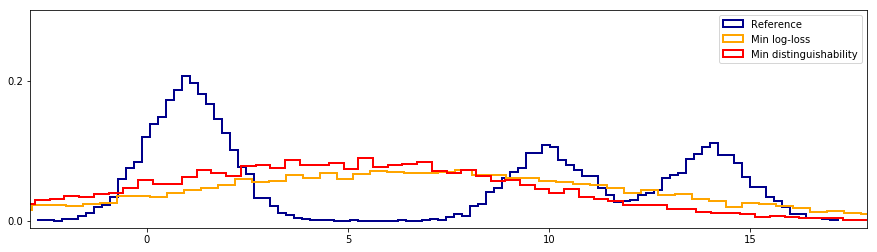

In [10]:
plt.figure(figsize=(15,4))
plt.hist(experimental_data,density=True,bins=100,histtype="step",color="darkblue",linewidth=2,label="Reference")
plt.hist(log_loss_data,density=True,bins=100,histtype="step",color="orange",linewidth=2,label="Min log-loss")
plt.hist(distinguishability_data,density=True,bins=100,histtype="step",color="red",linewidth=2,label="Min distinguishability")
plt.xticks([0,5,10,15])
plt.yticks([0.0,0.2])
plt.ylim(-0.01,0.3)
plt.xlim(-2.9,17.9)
plt.legend()
plt.show()

In [11]:
mu,sigma

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=4.6769643>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=4.7441816>)

In [12]:
experimental_data = generate_data([(1,1,3900),(14,1,3050),(10,1,3050)])

In [13]:
mu,sigma = fit_gaussian_log_loss(experimental_data,print_loss=False)
log_loss_data = np.random.normal(mu,sigma,10000)
mu,sigma = fit_gaussian_truncated_loss(experimental_data,mu,sigma,print_loss=False)
distinguishability_data = np.random.normal(mu,sigma,10000)

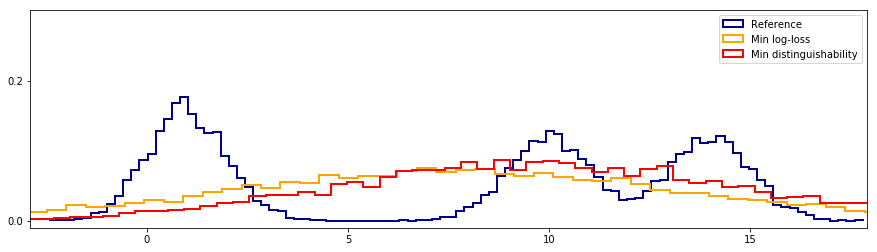

In [14]:
plt.figure(figsize=(15,4))
plt.hist(experimental_data,density=True,bins=100,histtype="step",color="darkblue",linewidth=2,label="Reference")
plt.hist(log_loss_data,density=True,bins=100,histtype="step",color="orange",linewidth=2,label="Min log-loss")
plt.hist(distinguishability_data,density=True,bins=100,histtype="step",color="red",linewidth=2,label="Min distinguishability")
plt.xticks([0,5,10,15])
plt.yticks([0.0,0.2])
plt.ylim(-0.01,0.3)
plt.xlim(-2.9,17.9)
plt.legend()
plt.show()

In [15]:
mu,sigma

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=9.559979>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=4.7951136>)